Tom Halloin <br> Springboard Data Science Career Track <br>

<h1 align="center">Capstone Project 2: Analysis of Berkshire Hathaway Shareholder Letters Using Natural Language Processing (NLP) Techniques</h1>

<h3 align='center'> Part 5: Topic Modelling</h3> <br>

This notebook tries to create a topic model visualization of Berkshire Hathaway's annual letters. Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [1]:
import gensim
import matplotlib.pyplot as plt
import nltk
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim
import re
import spacy
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.notebook import tqdm

Preprocessing: Loading English language Spacy model. Adding stop words that have showed up in previous iterations that are ambiguous or not helpful.

In [2]:
nlp = spacy.load('en_core_web_sm')

# Adding several stop words that showed up in original topics. Pronouns in general are not helpful and ambiguous.
nlp.Defaults.stop_words |= {'berkshire', 'berkshires', 'billion', 'billions', 'million', 'millions', 'that', 'they', 'this', 'which', 'what', 'year'}
stop_words = nlp.Defaults.stop_words

Loading all of the annual letters that are stored in a dictionary - cleaned from preprocessing earlier.

In [3]:
annual_letters = dict()
for year in range(1977, 2020):
    file = f'../clean_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='remove') as f:
        annual_letters[str(year)] = str(f.readlines())    

Creating a list of potential topics, stored by entity. Starts with tokenizing documents, then extracting entities, removing special characters such as punctutation and the dreaded non-breaking space (nbsp). Then filtering topics to make sure topic is at least 4 characters long and not a stop word.

In [4]:
text_data = []
# Iterates through each article in the corpus.
for year in tqdm(annual_letters):
    # Passes that article through the pipeline and adds to a new list.
    tokenized_letter = nlp(annual_letters[year])
    entities = [str(ent).lower() for ent in tokenized_letter.ents if ent.label_ != 'MONEY']
    ents_without_numbers = [re.sub('[,$%0-9.;&()]', '', ent) for ent in entities]
    remove_non_breaking_spaces = [re.sub('(nbsp)', '', ent) for ent in ents_without_numbers]
    potential_words = [chunk for chunk in remove_non_breaking_spaces if len(chunk) > 3]
    potential_words = [topic for topic in potential_words if topic not in stop_words]
    text_data.append(potential_words)

Creating a dictionary from the data, then convert to bag-of-words corpus using the gensim corpora package.

In [5]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

Computing coherence scores to measure quality of topics. Higher score -> more cohesive topics.

In [18]:
coherence_model_scores = []
for n in tqdm(range(5, 25)):
    model=gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=n, passes=100, per_word_topics=True)
    coherence_model_lda = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_lda.get_coherence())

Plotting the coherence scores based on the number of topics.

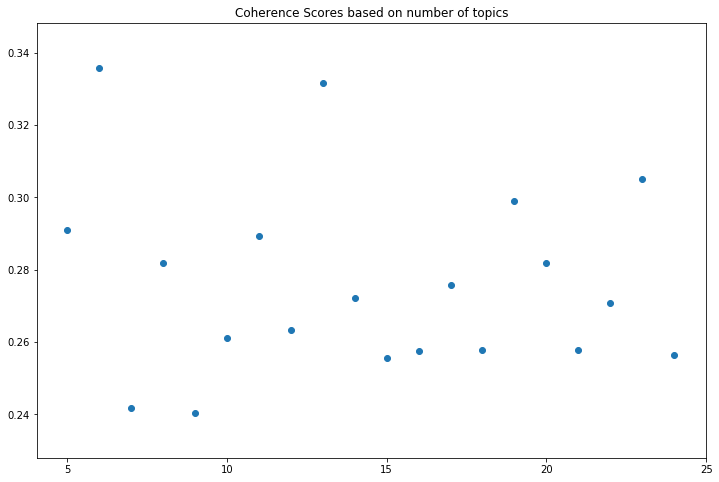

In [19]:

f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

Creating the actual topic model. Put num_topics as the value with one of the highest coherence scores, or a really low number if topics are too sparse.

In [20]:
NUM_TOPICS = coherence_model_scores.index(max(coherence_model_scores)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = NUM_TOPICS, passes=100, per_word_topics=True)

In [9]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis


C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.009120 -0.001477       1        1  44.412960
4      0.012670 -0.006187       2        1  37.333660
0     -0.008867 -0.001021       3        1   9.243937
1      0.005831  0.009507       4        1   7.449406
2     -0.000514 -0.000822       5        1   1.560042, topic_info=     Category        Freq                     Term       Total  loglift  \
407   Default  538.000000                  charlie  538.000000  30.0000   
57    Default  480.000000                last year  480.000000  29.0000   
9     Default  311.000000                   annual  311.000000  28.0000   
116   Default  240.000000                   about   240.000000  27.0000   
419   Default  156.000000                     gaap  156.000000  26.0000   
...       ...         ...                      ...         ...      ...   
3823   Topic5    0.959390                     bnsf   72.065941  -0.1586   
558    Topic5    0.930330                    years   75.680168  -0.2383   
1181   Topic5    0.823448                am to  pm   54.980625  -0.0408   
2542   Topic5    0.829434                  netjets   77.131027  -0.3721   
617    Topic5    0.788343  nebraska furniture mart   70.324440  -0.3305   

      logprob  
407   30.0000  
57    29.0000  
9     28.0000  
116   27.0000  
419   26.0000  
...       ...  
3823  -5.7776  
558   -5.8083  
1181  -5.9304  
2542  -5.9231  
617   -5.9739  

[413 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
475       1  0.835702       acres
1181      1  0.454706   am to  pm
1181      2  0.381953   am to  pm
1181      3  0.072753   am to  pm
1181      4  0.072753   am to  pm
...     ...       ...         ...
396       1  0.559873        zero
396       2  0.279937        zero
396       3  0.093312        zero
396       4  0.046656        zero
396       5  0.023328        zero

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

To compare, I am also going to use Mallet LDA. Mallet is known to provide better topics.

In [10]:

## Setup mallet environment change it according to your drive
os.environ.update({'MALLET_HOME':r'C:/Users/Tom/Documents/Berkshire/Milestone_1/mallet-2.0.8'})
## Setup mallet path change it according to your drive
mallet_path = 'C:/Users/Tom/Documents/Berkshire/Milestone_1/mallet-2.0.8/bin/mallet'



In [11]:
coherence_model_scores = []
for n in tqdm(range(5, 25)):
    model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=dictionary)
    coherence_model_mallet = CoherenceModel(model, texts=text_data, dictionary=dictionary, coherence='c_v')
    coherence_model_scores.append(coherence_model_mallet.get_coherence())

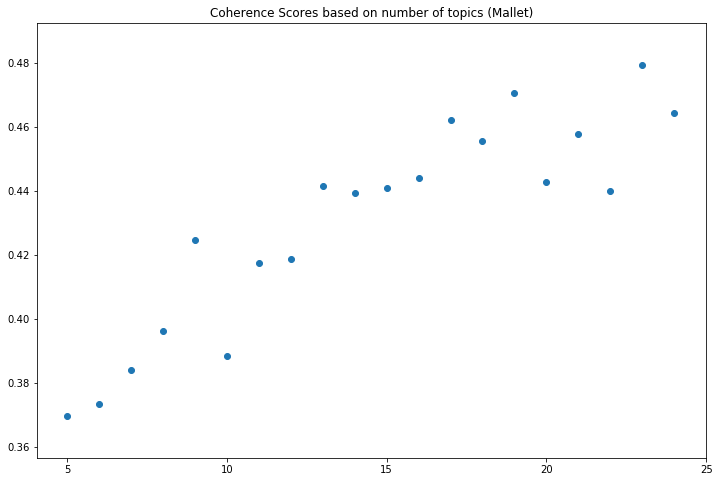

In [12]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 25)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Mallet)')
ax.set_xticks([5*x + 5 for x in range(5)])
plt.show()

In [15]:
NUM_TOPICS = 9 # After testing, this provided the "best" topics
model=gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Tom\Anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.229579 -0.195540       1        1  17.866195
4      0.268367 -0.018424       2        1  16.830800
0      0.146628  0.170395       3        1  11.508995
8      0.202610 -0.009100       4        1  11.344483
7     -0.188435 -0.062060       5        1  10.335342
3     -0.157774 -0.127257       6        1   9.193382
1     -0.112300 -0.084354       7        1   9.175459
6     -0.309572 -0.048877       8        1   7.936623
5     -0.079102  0.375217       9        1   5.808722, topic_info=     Category         Freq      Term        Total  loglift  logprob
395   Default  1467.000000     years  1467.000000  30.0000  30.0000
7     Default   273.000000  american   273.000000  29.0000  29.0000
1217  Default   371.000000   company   371.000000  28.0000  28.0000
3281  Default   195.000000     scott   195.000000  27.0000  27.0000
9     Default   486.000000    annual   486.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
431    Topic9    12.018004   october    31.441488   1.8841  -4.5643
349    Topic9    12.018004      loan    36.287855   1.7407  -4.5643
346    Topic9    13.353337    kansas    71.204144   1.1720  -4.4590
1753   Topic9    13.353337      post   111.340405   0.7250  -4.4590
134    Topic9    10.682670     frank    45.087614   1.4058  -4.6821

[690 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
292       8  0.959164     -owned
1522      3  1.318508  -year-old
4549      4  0.675471      //-//
1886      8  0.959164      abner
930       6  0.768351    accrued
...     ...       ...        ...
395       1  0.029983      years
395       5  0.327088      years
395       6  0.134924      years
395       7  0.280069      years
395       8  0.228280      years

[736 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 9, 8, 4, 2, 7, 6])

In [21]:
# Printing the words and weights for each part of the topic model.
from pprint import pprint
pprint(ldamodel.print_topics())

[(0,
  '0.011*"annually" + 0.011*"blue chip stamps" + 0.010*"annual" + '
  '0.009*"berkshire’s" + 0.008*"berkshire hathaway" + 0.008*"california" + '
  '0.008*"wesco" + 0.007*"about " + 0.007*"blue chip" + 0.007*"american"'),
 (1,
  '0.014*"geico" + 0.012*"last year" + 0.011*"charlie" + 0.010*"less than '
  'zero" + 0.010*"second" + 0.009*"disney" + 0.008*"this year" + 0.007*"about '
  '" + 0.006*"bill" + 0.005*"rc willey"'),
 (2,
  '0.014*"zero" + 0.012*"charlie" + 0.009*"sunday" + 0.009*"second" + '
  '0.008*"last year" + 0.007*"annually" + 0.007*"annual" + 0.006*"geico" + '
  '0.005*"the year" + 0.005*"american"'),
 (3,
  '0.033*"charlie" + 0.031*"last year" + 0.020*"annual" + 0.015*"about " + '
  '0.012*"second" + 0.010*"gaap" + 0.010*"today" + 0.009*"annually" + '
  '0.008*"geico" + 0.008*"omaha"'),
 (4,
  '0.017*"charlie" + 0.016*"gaap" + 0.008*"arcata" + 0.007*"dave" + '
  '0.006*"about " + 0.006*"last year" + 0.006*"annual" + 0.005*"salomon" + '
  '0.005*"omaha" + 0.004*"today"